# Обучение нейросети для 3 части пайплайна распознавания лиц на CE loss. Использована нейросеть ResNet34, предобученная на ImageNet

# Загрузка данных

Скачивание данных с гугл диска

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Данные, которые мы будем использовать при обучении это выровненные изображения лиц 500 людей CelebA-500: https://disk.yandex.ru/d/S8f03spLIA1wrw
Внутри:


```
  - celebA_imgs — папка с выровненными картинками;
  - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;
  - celebA_train_split.txt — файл со сплитом на train/val/test.
```

In [2]:
!unzip -uq "/content/drive/MyDrive/Datasets Deep Learning/celebA_train_500.zip" -d "/content/celebA_train_500"

In [3]:
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np
import tqdm
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tt
from PIL import Image
import pandas as pd

# Добавление аугментации к тренировочным данным

В исходном train датасете находится 8544 изображения. Всего у нас 500 классов. Значит на каждый класс приходится в среднем около 17 изображений и такого количества образцов может быть недостаточно для качественного обучения модели. Поэтому я применяю аугментацию. Это должно повысить обобщающей способности модели, предотвратить её переобучение и улучшить качество классификации.

Создадим датасеты на основе файлов anno_file и split_file, они нам понадобятся далее

In [4]:
anno_file = '/content/celebA_train_500/celebA_train_500/celebA_anno.txt'
annotations = pd.read_csv(anno_file, sep=' ', header=None, names=['image', 'id'])

In [5]:
split_file = '/content/celebA_train_500/celebA_train_500/celebA_train_split.txt'
splits = pd.read_csv(split_file, sep=' ', header=None, names=['image', 'split'])

In [6]:
annotations

,image,id
0,000001.jpg,0
1,000404.jpg,0
2,003415.jpg,0
3,004390.jpg,0
4,018062.jpg,0
...,...,...
12006,126297.jpg,499
12007,129725.jpg,499
12008,132679.jpg,499
12009,151415.jpg,499


In [7]:
splits

,image,split
0,000001.jpg,0
1,000404.jpg,0
2,003415.jpg,0
3,004390.jpg,0
4,018062.jpg,0
...,...,...
12006,126297.jpg,1
12007,129725.jpg,2
12008,132679.jpg,2
12009,151415.jpg,2


Зададим трансформации, они представляют собой применение отражения по горизонтали, небольшого случайного поворота и случайные изменения яркости, контрастности и насыщенности изображения. Это сделает тренировочные данные более вариативными.

In [8]:
augmentations = tt.Compose([
    tt.RandomHorizontalFlip(p=0.5),
    tt.RandomRotation(degrees=15),
    tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    tt.ToTensor()
])

Ячейка ниже производит создание аугментированных изображений для train датасета и создание новой папки, где будут храниться исходные изображения + аугментированные. Для каждого изображения из train датасета будет создано по 3 аугментированных копии. Таким образом размер тренировочного датасета увеличится в 4 раза, с 8544 изображений до 34176 изображений

In [31]:
image_folder = '/content/celebA_train_500/celebA_train_500/celebA_imgs' # старая папка с изображениями
new_image_folder = '/content/celebA_train_500/celebA_train_500/celebA_imgs_with_augmentations' # новая папка, где помимо исходных изображений будут аугментированные

os.makedirs(new_image_folder, exist_ok=True)
num_augmentations = 3 # количество аугментированных копий для каждого изображения

new_annotations = []
new_splits = []

# в данном цикле проходимся по всем изображениям из исходного датасета и сохраняем их в папку new_image_folder
for _, row in tqdm.tqdm(splits.iterrows(), total = len(splits)):
    image_name = row['image']
    image_id = annotations[annotations['image'] == image_name]['id'].values[0]
    image_path = os.path.join(image_folder, image_name)
    image = Image.open(image_path).convert('RGB')
    image.save(os.path.join(new_image_folder, image_name))
    if row['split'] == 0: # если изображение из train, создаём для него аугментации
      for i in range(num_augmentations):
        augmented_image = augmentations(image)

        new_image_name = f"{os.path.splitext(image_name)[0]}_aug{i+1}.jpg"
        new_image_path = os.path.join(new_image_folder, new_image_name)
        augmented_image_pil = tt.ToPILImage()(augmented_image)
        augmented_image_pil.save(new_image_path)

        # так как теперь изображения хранятся в новой папке, создадим для них новые словари с аннотациями и сплитами
        new_annotations.append({'image': new_image_name, 'id': image_id})

        new_splits.append({'image': new_image_name, 'split': 0})

100%|██████████| 12011/12011 [02:08<00:00, 93.33it/s]


В ячейке ниже создаём файлы с аннонациями и сплитами аналогично тому, как это было в исходном датасете

In [32]:
new_annotations_df = pd.DataFrame(new_annotations)
updated_annotations = pd.concat([annotations, new_annotations_df], ignore_index=True)
updated_annotations.to_csv('/content/celebA_train_500/celebA_train_500/celebA_anno_updated.txt', sep=' ', header=False, index=False)

new_splits_df = pd.DataFrame(new_splits)
updated_splits = pd.concat([splits, new_splits_df], ignore_index=True)
updated_splits.to_csv('/content/celebA_train_500/celebA_train_500/celebA_train_split_updated.txt', sep=' ', header=False, index=False)

In [33]:
updated_annotations.shape

(37643, 2)

In [34]:
updated_splits.shape

(37643, 2)

Реализуем для наших данных класс CelebADataset и функцию get_dataloaders

In [36]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, anno_file, split_file, split_type, transform = None):
        """
        :param img_dir: Путь к папке с изображениями (celebA_imgs)
        :param anno_file: Путь к файлу с аннотациями (celebA_anno.txt)
        :param split_file: Путь к файлу сплитов (celebA_train_split.txt)
        :param split_type: Тип выборки ('train', 'val' или 'test')
        :param transform: Трансформации для изображений
        """
        self.img_dir = img_dir
        self.transform = transform

        # Словарь вида {изображение: номер класса}
        self.img_to_class = {}
        with open(anno_file, 'r') as f:
            for line in f:
                img_name, class_id = line.strip().split() # добавляем имя изображения в img_name, номер класса изображения в class_id
                self.img_to_class[img_name] = int(class_id) # добавляем в словарь по ключу img_name значение class_id

        # Список изображений train/val/test выборки в зависимости от значения split_type
        self.img_list = []
        split_map = {'train': 0, 'val': 1, 'test': 2}
        with open(split_file, 'r') as f:
            for line in f:
                img_name, split_id = line.strip().split()
                if int(split_id) == split_map[split_type]: # проверка, соответствует ли id данного изображения текущему значению split_type
                    self.img_list.append(img_name)

    def __len__(self):
        return len(self.img_list)


    # Метод получения изображения выборки по заданному индексу
    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        label = self.img_to_class[img_name]

        if self.transform:
            image = np.array(image)
            image = Image.fromarray(image[77:-41, 45:-50]) # обрезка изображения
            image = self.transform(image)

        return image, label

In [37]:
# Функция для создания DataLoader
def get_dataloaders(img_dir, anno_file, split_file, image_size_after_resize, image_size_after_crop, batch_size, stats):
    """
    Создает train, test и val DataLoader
    :param img_dir: Путь к папке с изображениями
    :param anno_file: Путь к файлу аннотаций
    :param split_file: Путь к файлу сплитов
    :param image_size_after_resize: Размер изображения, который будет при применении resize
    :param image_size_after_crop: Размер изображения, который будет получен при применении center crop
    :param batch_size: Размер батча
    :param stats: Параметры нормализации, stats имеет вид ((mean1, mean2, mean2), (std1, std2, std3))
    :return: Словарь с DataLoader для train, val и test
    """
    # Трансформация изображения для train выборки (с аугментацией)
    #transform_with_augmentation = tt.Compose([
    #    tt.RandomHorizontalFlip(p=0.5),  # горизонтальное отражение
    #    tt.RandomRotation(degrees=15),  # cлучайное вращение на ±15 градусов
    #    tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # изменение цвета
    #    tt.Resize(image_size_after_resize), # изменение размера
    #    tt.ToTensor(),
    #    tt.Normalize(mean=stats[0], std=stats[1])
    #])

    # Трансформация изображения для val и test выборки (без аугментации)
    transform = tt.Compose([
        tt.Resize(image_size_after_resize),
        tt.ToTensor(),
        tt.Normalize(mean=stats[0], std=stats[1])
    ])

    # Создание кастомных датасетов
    train_dataset = CelebADataset(img_dir, anno_file, split_file, 'train', transform)
    val_dataset = CelebADataset(img_dir, anno_file, split_file, 'val', transform)
    test_dataset = CelebADataset(img_dir, anno_file, split_file, 'test', transform)
    # Создание DataLoader, shuffle = True только для train выборки
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return {'train': train_loader, 'val': val_loader, 'test': test_loader}


In [38]:
images_dir_aug = '/content/celebA_train_500/celebA_train_500/celebA_imgs_with_augmentations'
anno_dir_aug = '/content/celebA_train_500/celebA_train_500/celebA_anno_updated.txt'
split_dir_aug = '/content/celebA_train_500/celebA_train_500/celebA_train_split_updated.txt'
image_size_after_resize = (280, 280)
image_size_after_crop = (224, 224)
batch_size = 256
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

Создание тренировочного, валидационного и тестового даталоадеров.

In [39]:
dataloaders = get_dataloaders(images_dir_aug, anno_dir_aug, split_dir_aug, image_size_after_resize, image_size_after_crop, batch_size, stats)
# создаём отдельно train, val и test dataloader'ы
train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

In [40]:
train_size = len(CelebADataset(images_dir_aug, anno_dir_aug, split_dir_aug, 'train'))
val_size = len(CelebADataset(images_dir_aug, anno_dir_aug, split_dir_aug, 'val'))
test_size = len(CelebADataset(images_dir_aug, anno_dir_aug, split_dir_aug, 'test'))

Посмотрим на размеры train, val, test выборки. Убедимся, что после аугментации train выборка стала в 4 раза больше относительно исходной, а val и test не изменились, так как к ним аугментация не применялась.

In [41]:
print(f'Размер train: {train_size}, размер val: {val_size}, размер test: {test_size}')

Размер train: 34176, размер val: 1878, размер test: 1589


# Вывод некоторых изображений датасета

Импорт необходимых библиотек

In [42]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [43]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [44]:
def show_images(images, nmax=16):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=4).permute(1, 2, 0))

def show_batch(dl, nmax=16):
    for images, _ in dl:
        show_images(images, nmax)
        break

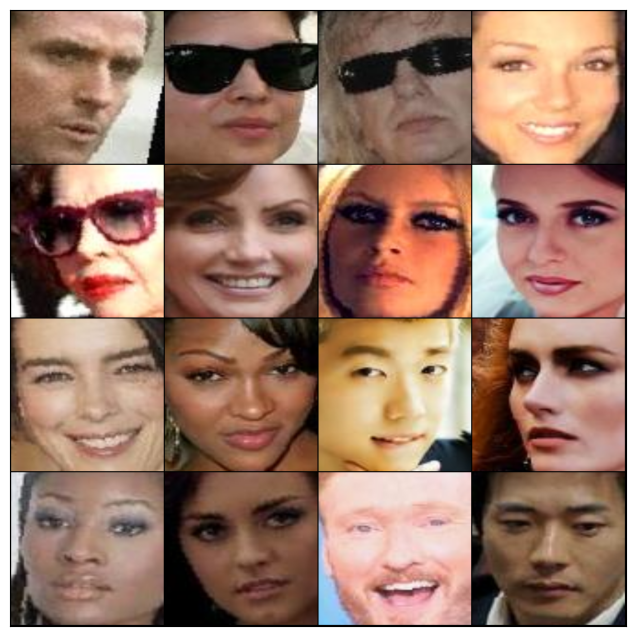

In [45]:
show_batch(train_loader)

In [46]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# Функции обучения и тестирования модели

Напишем отдельный класс, реализующий критерий останова цикла обучения. Идея в том, что если на протяжении заданного числа эпох нужный нам параметр, обычно это лосс, значимо не меняется, то мы останавливаем обучение.

In [47]:
class EarlyStopping:
  def __init__(self, mode = 'min', patience = 10, threshold = 0.0001, threshold_mode = 'rel'):
    '''
    Параметры:
        mode (str): режим изменения отслеживаемого параметра, 'min' или 'max'
        patience (int): количество эпох, по истечении которого срабатывает критерий останова
        threshold (float): порог изменения отслеживаемого параметра
        threshold_mode (str): режим сравнения (абсолютное или относительное изменение)
    '''
    # проверка, что переданные параметры имеют правильные значения
    if mode not in ['min', 'max']:
      raise ValueError(f'Параметр mode может принимать только значения max и min')
    if threshold_mode not in ('rel', 'abs'):
      raise ValueError(f'Параметр threshold_made может принимать только значения abs и rel')
    if not isinstance(patience, int):
      raise TypeError(f'Параметр patience может принимать только целые значения')
    if not isinstance(threshold, float):
      raise TypeError(f'Параметр threshold должен быть float и < 1.0')
    if threshold >= 1.0:
      raise ValueError(f'Параметр threshold должен быть < 1.0')

    self.mode = mode
    self.patience = patience
    self.threshold = threshold
    self.threshold_mode = threshold_mode
    self.count = 0
    self.best = None

  def __call__(self, tracking_parameter):
    '''
    Параметры:
        tracking_parameter: значение функции потерь или значение метрики

    '''
    current = float(tracking_parameter)
    # если лучшее значение отслеживаемого параметра не задано, то задаём его
    if self.best is None:
      self.best = current
      return False

    # проверяем улучшила ли модель значение отслеживаемого параметра
    if self.changed_better(current, self.best): # если да, то обнуляем значения счётчика
      self.best = current
      self.count = 0
    else:
      self.count += 1 # если значение отслеживаемого параметра не улучшилось, увеличиваем счётчик на 1

    if self.count >= self.patience: # если превышается значение "терпения", то обучение останавливается
      self.count = 0
      return True
    return False

  def changed_better(self, current, best):
    '''
    Проверяет, улучшила ли модель свои показатели

    Параметры:
        current (float): текущее значение отслеживаемого параметра
        best (float): лучшее значение отслеживаемого параметра
    '''
    if self.mode == 'min' and self.threshold_mode == 'rel':
      return current < best - best * self.threshold

    elif self.mode == 'min' and self.threshold_mode == 'abs':
      return current < best - self.threshold

    elif self.mode == 'max' and self.threshold_mode == 'rel':
      return current > best + best * self.threshold

    else:
      return current > best + self.threshold


**Реализация циклов обучения и тестирования модели**

In [48]:
def train_model(model, train_loader, val_loader, criterion, optimizer, earlystopping, start_epoch, num_epochs):
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []
  lr_list = []
  best_loss = None
  count = 0 # отсчёт эпох, в которых нет улучшения лосса
  for epoch in range(start_epoch, start_epoch + num_epochs):
    # тренировка модели
    model.train()
    running_train_loss = []
    running_val_loss = []
    train_loop = tqdm.tqdm(train_loader, leave = False)
    correct_predictions_on_train = 0
    correct_predictions_on_val = 0
    total_train = 0
    total_validation = 0
    for images, labels in train_loop:
        # прямой проход + подсчёт ошибки модели
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        # обратный проход
        optimizer.zero_grad()
        loss.backward()
        # шаг оптимизации
        optimizer.step()

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)

        _, predictions = outputs.max(1)
        total_train += labels.size(0)
        correct_predictions_on_train += predictions.eq(labels).sum().item()

        train_loop.set_description(f'Epoch [{epoch}/{start_epoch + num_epochs - 1}], train_loss={mean_train_loss:.4f}')

    # Расчёт значения метрики
    running_train_acc = 100. * correct_predictions_on_train / total_train

    # Сохранение значения функции потерь и метрики
    train_acc.append(running_train_acc)
    train_loss.append(mean_train_loss)

    # Валидация модели
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            # прямой проход и расчет ошибки модели
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)

            _, predictions = outputs.max(1)
            total_validation += labels.size(0)
            correct_predictions_on_val += predictions.eq(labels).sum().item()

        # Расчёт значения метрики
        running_val_acc = 100. * correct_predictions_on_val / total_validation

        # Сохранение значения функции потерь и метрики
        val_acc.append(running_val_acc)
        val_loss.append(mean_val_loss)

    lr_scheduler.step()
    last_lr = lr_scheduler._last_lr[0]
    lr_list.append(last_lr)

    print(f'Epoch [{epoch}/{start_epoch + num_epochs - 1}], train_loss: {mean_train_loss:.4f}, val Loss: {mean_val_loss:.4f}, val accuracy: {running_val_acc:.4f} %, train_accuracy: {running_train_acc:.4f} %, lr: {last_lr:.4f}')

    if best_loss is None:
        best_loss = mean_val_loss

    if mean_val_loss < best_loss: # если модель улучшила лосс, отсчёт эпох идёт заново
        best_loss = mean_val_loss
        count = 0

        checkpoint = {
            'state_model': model.state_dict(),
            'state_opt': optimizer.state_dict(),
            'state_lr_scheduler': lr_scheduler.state_dict(),
            'loss': {'train_loss': train_loss,
                     'val_loss': val_loss,
                     'best_loss': best_loss
            },
            'metric': {
                'train_acc': train_acc,
                'val_acc': val_acc,
            },
            'lr': lr_list,
            'epoch': {
                'EPOCHS': num_epochs,
                'save_epoch': epoch
            }
        }
        torch.save(checkpoint, f'model_state_dict_epoch_{epoch}.pt')
        print(f"Сохранена модель со значением val loss = {mean_val_loss:.4f} на эпохе {epoch}")

    if earlystopping(mean_val_loss):
      print(f"\033[31mОбучение остановлено на {epoch} эпохе.\033[0m")
      break
  return {'loss': {'train_loss': train_loss,
                     'val_loss': val_loss,
            },
            'metric': {
                'train_acc': train_acc,
                'val_acc': val_acc,
            },
            'lr': lr_list}

In [63]:
def test_model(model, criterion, test_loader):
   test_acc = 0
   running_test_loss = []
   total_test = 0
   correct_predictions_on_test = 0
   model.eval()
   with torch.no_grad():
       for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # прямой проход и расчет ошибки модели
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_test_loss.append(loss.item())
            mean_test_loss = sum(running_test_loss)/len(running_test_loss)

            _, predictions = outputs.max(1)
            total_test += labels.size(0)
            correct_predictions_on_test += predictions.eq(labels).sum().item()

       # Расчёт значения метрики
       test_acc = 100. * correct_predictions_on_test / total_test

       return {'test_acc': test_acc, 'test_loss': mean_test_loss}

Возьмём предобученную на ImageNet модель resnet34 и обучим её на нашем датасете. Помимо resnet34 я также пробовал использовать такие предобученные модели как resnet18, resnet50. Обучение модели resnet50 занимало дольше времени, чем обучение других моделей, и она не давала быстрой сходимости, поэтому выбрана модель resnet34 в качестве оптимального варианта по скорости и сложности.

Я изменил классификатор на dropout + линейный слой.

1.  Сначала обучил на 10 эпохах с размороженными весами классификатора и замороженными весами feature extractor'а
2.  Дообучил модель на 20 эпохах с размороженными весами классификатора и с размороженными весами слоя layer4 в feature extractor'e
3.  Дообучил модель на 20 эпохах с размороженными весами классификатора, слоя layer4 в feature extractor'e и слоя layer3 в в feature extractor'e

**В итоге удалось получить accuracy на тесте чуть более 72 %.**

# 1 - й этап обучения: разморожен классификатор, заморожен feature extractor'а, 10 эпох

In [ ]:
model = models.resnet34(weights = 'DEFAULT')

In [ ]:
from torch.nn import Sequential, Linear, ReLU, Dropout

in_features = model.fc.in_features
model.fc = Sequential(
    Dropout(p=0.5),
    Linear(in_features, 500)
)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
for name, layer in model.named_modules():
  if isinstance(layer, (nn.Conv2d, nn.Linear)):
    print(name)
    for i, param in enumerate(layer.parameters()):
      if i == 0:
        print(f' weights.requires_grad = {param.requires_grad}')
      else:
        print(f' bias.requires_grad    = {param.requires_grad}', end = "\n\n")

conv1
 weights.requires_grad = False
layer1.0.conv1
 weights.requires_grad = False
layer1.0.conv2
 weights.requires_grad = False
layer1.1.conv1
 weights.requires_grad = False
layer1.1.conv2
 weights.requires_grad = False
layer1.2.conv1
 weights.requires_grad = False
layer1.2.conv2
 weights.requires_grad = False
layer2.0.conv1
 weights.requires_grad = False
layer2.0.conv2
 weights.requires_grad = False
layer2.0.downsample.0
 weights.requires_grad = False
layer2.1.conv1
 weights.requires_grad = False
layer2.1.conv2
 weights.requires_grad = False
layer2.2.conv1
 weights.requires_grad = False
layer2.2.conv2
 weights.requires_grad = False
layer2.3.conv1
 weights.requires_grad = False
layer2.3.conv2
 weights.requires_grad = False
layer3.0.conv1
 weights.requires_grad = False
layer3.0.conv2
 weights.requires_grad = False
layer3.0.downsample.0
 weights.requires_grad = False
layer3.1.conv1
 weights.requires_grad = False
layer3.1.conv2
 weights.requires_grad = False
layer3.2.conv1
 weights.requi

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr = 0.01)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.99)
earlystopping = EarlyStopping(mode = 'min', patience = 10)

Обучим модель на 10 эпохах с размороженными весами классификатора и замороженными весами feature extractor'а

In [ ]:
num_epochs = 10
start_epoch = 1
train_model(model, train_loader, val_loader, criterion, optimizer, earlystopping, start_epoch, num_epochs)

Epoch [1/10], train_loss: 7.1916, val Loss: 5.4789, val accuracy: 9.2119 %, train_accuracy: 2.9728 %, lr: 0.0099


Epoch [2/10], train_loss: 6.2094, val Loss: 5.4170, val accuracy: 10.9691 %, train_accuracy: 8.1344 %, lr: 0.0098
Сохранена модель со значением val loss = 5.4170 на эпохе 2


Epoch [3/10], train_loss: 6.3025, val Loss: 5.3458, val accuracy: 12.6198 %, train_accuracy: 9.6325 %, lr: 0.0097
Сохранена модель со значением val loss = 5.3458 на эпохе 3


Epoch [4/10], train_loss: 6.3480, val Loss: 5.2504, val accuracy: 14.0043 %, train_accuracy: 10.6332 %, lr: 0.0096
Сохранена модель со значением val loss = 5.2504 на эпохе 4


Epoch [5/10], train_loss: 6.4474, val Loss: 5.2354, val accuracy: 14.8030 %, train_accuracy: 10.9726 %, lr: 0.0095
Сохранена модель со значением val loss = 5.2354 на эпохе 5


Epoch [6/10], train_loss: 6.4215, val Loss: 5.4547, val accuracy: 13.9510 %, train_accuracy: 11.6807 %, lr: 0.0094


Epoch [7/10], train_loss: 6.4118, val Loss: 5.2830, val accuracy: 15.3887 %, train_accuracy: 11.7480 %, lr: 0.0093


Epoch [8/10], train_loss: 6.4850, val Loss: 5.4953, val accuracy: 14.8562 %, train_accuracy: 12.2132 %, lr: 0.0092


Epoch [9/10], train_loss: 6.5155, val Loss: 5.3812, val accuracy: 15.4420 %, train_accuracy: 11.8036 %, lr: 0.0091


Epoch [10/10], train_loss: 6.5247, val Loss: 5.2382, val accuracy: 15.8679 %, train_accuracy: 12.1255 %, lr: 0.0090


{'loss': {'train_loss': [7.1915837152680355,
   6.209433502225734,
   6.302488643731644,
   6.347967966278987,
   6.447397733802226,
   6.42148987926654,
   6.411788381747345,
   6.484971057123213,
   6.515549061903313,
   6.524749449829557],
  'val_loss': [5.478851556777954,
   5.416981399059296,
   5.345781683921814,
   5.250411093235016,
   5.235364496707916,
   5.454732120037079,
   5.2830116748809814,
   5.495333433151245,
   5.381151854991913,
   5.238222718238831]},
 'metric': {'train_acc': [2.9728464419475658,
   8.13436329588015,
   9.63249063670412,
   10.63319288389513,
   10.972612359550562,
   11.680711610486892,
   11.748010299625468,
   12.213249063670412,
   11.803604868913858,
   12.125468164794007],
  'val_acc': [9.211927582534612,
   10.969116080937168,
   12.619808306709265,
   14.004259850905218,
   14.802981895633653,
   13.95101171458999,
   15.388711395101172,
   14.856230031948881,
   15.4419595314164,
   15.867944621938232]},
 'lr': [0.0099,
  0.009801,
  0.00

In [ ]:
torch.save(model.state_dict(), f'model_state_dict_10.pt')

In [ ]:
train_loss_epochs_1_10 = [
   7.1915837152680355,
   6.209433502225734,
   6.302488643731644,
   6.347967966278987,
   6.447397733802226,
   6.42148987926654,
   6.411788381747345,
   6.484971057123213,
   6.515549061903313,
   6.524749449829557]
val_loss_epochs_1_10 = [
   5.478851556777954,
   5.416981399059296,
   5.345781683921814,
   5.250411093235016,
   5.235364496707916,
   5.454732120037079,
   5.2830116748809814,
   5.495333433151245,
   5.381151854991913,
   5.238222718238831]
train_acc_epochs_1_10 = [
   2.9728464419475658,
   8.13436329588015,
   9.63249063670412,
   10.63319288389513,
   10.972612359550562,
   11.680711610486892,
   11.748010299625468,
   12.213249063670412,
   11.803604868913858,
   12.125468164794007]
val_acc_epochs_1_10 = [
   9.211927582534612,
   10.969116080937168,
   12.619808306709265,
   14.004259850905218,
   14.802981895633653,
   13.95101171458999,
   15.388711395101172,
   14.856230031948881,
   15.4419595314164,
   15.867944621938232]

Дообучение нашей модели, но уже с размороженными весами слоя layer4. То есть теперь разморожены веса fully connected слоя и layer4.

In [ ]:
load_model_state = torch.load('model_state_dict_epoch_10.pt')

<ipython-input-31-db7ac18b1b86>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model_state = torch.load('model_state_dict_epoch_10.pt')


# 2 - й этап обучения: разморожен классификатор и слой layer4 в feature extractor'e, 20 эпох

In [ ]:
model = models.resnet34()

In [ ]:
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, 500)
)

In [ ]:
model.load_state_dict(load_model_state)

<All keys matched successfully>

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
for name, layer in model.named_modules():
  if isinstance(layer, (nn.Conv2d, nn.Linear)):
    print(name)
    for i, param in enumerate(layer.parameters()):
      if i == 0:
        print(f' weights.requires_grad = {param.requires_grad}')
      else:
        print(f' bias.requires_grad    = {param.requires_grad}', end = "\n\n")

conv1
 weights.requires_grad = False
layer1.0.conv1
 weights.requires_grad = False
layer1.0.conv2
 weights.requires_grad = False
layer1.1.conv1
 weights.requires_grad = False
layer1.1.conv2
 weights.requires_grad = False
layer1.2.conv1
 weights.requires_grad = False
layer1.2.conv2
 weights.requires_grad = False
layer2.0.conv1
 weights.requires_grad = False
layer2.0.conv2
 weights.requires_grad = False
layer2.0.downsample.0
 weights.requires_grad = False
layer2.1.conv1
 weights.requires_grad = False
layer2.1.conv2
 weights.requires_grad = False
layer2.2.conv1
 weights.requires_grad = False
layer2.2.conv2
 weights.requires_grad = False
layer2.3.conv1
 weights.requires_grad = False
layer2.3.conv2
 weights.requires_grad = False
layer3.0.conv1
 weights.requires_grad = False
layer3.0.conv2
 weights.requires_grad = False
layer3.0.downsample.0
 weights.requires_grad = False
layer3.1.conv1
 weights.requires_grad = False
layer3.1.conv2
 weights.requires_grad = False
layer3.2.conv1
 weights.requi

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
], weight_decay = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
earlystopping = EarlyStopping(mode = 'min', patience = 10)

In [ ]:
start_epoch = 11
num_epochs = 20
train_model(model, train_loader, val_loader, criterion, optimizer, earlystopping, start_epoch, num_epochs)

Epoch [11/31], train_loss: 4.7001, val Loss: 3.1838, val accuracy: 38.1257%, lr: 0.0001


Epoch [12/31], train_loss: 2.9056, val Loss: 2.7143, val accuracy: 44.5687%, lr: 0.0001
Сохранена модель со значением val loss = 2.7143 на эпохе 12


Epoch [13/31], train_loss: 2.0655, val Loss: 2.5396, val accuracy: 47.5506%, lr: 0.0001
Сохранена модель со значением val loss = 2.5396 на эпохе 13


Epoch [14/31], train_loss: 1.5025, val Loss: 2.3672, val accuracy: 52.2364%, lr: 0.0001
Сохранена модель со значением val loss = 2.3672 на эпохе 14


Epoch [15/31], train_loss: 1.1159, val Loss: 2.2767, val accuracy: 53.4611%, lr: 0.0001
Сохранена модель со значением val loss = 2.2767 на эпохе 15


Epoch [16/31], train_loss: 0.8257, val Loss: 2.2254, val accuracy: 54.1534%, lr: 0.0001
Сохранена модель со значением val loss = 2.2254 на эпохе 16


Epoch [17/31], train_loss: 0.6143, val Loss: 2.2014, val accuracy: 54.6858%, lr: 0.0001
Сохранена модель со значением val loss = 2.2014 на эпохе 17


Epoch [18/31], train_loss: 0.4714, val Loss: 2.1618, val accuracy: 55.4313%, lr: 0.0001
Сохранена модель со значением val loss = 2.1618 на эпохе 18


Epoch [19/31], train_loss: 0.3693, val Loss: 2.1199, val accuracy: 56.8158%, lr: 0.0001
Сохранена модель со значением val loss = 2.1199 на эпохе 19


Epoch [20/31], train_loss: 0.2955, val Loss: 2.1166, val accuracy: 56.3365%, lr: 0.0001
Сохранена модель со значением val loss = 2.1166 на эпохе 20


Epoch [21/31], train_loss: 0.2453, val Loss: 2.0846, val accuracy: 57.5080%, lr: 0.0001
Сохранена модель со значением val loss = 2.0846 на эпохе 21


Epoch [22/31], train_loss: 0.1951, val Loss: 2.0716, val accuracy: 57.6677%, lr: 0.0001
Сохранена модель со значением val loss = 2.0716 на эпохе 22


Epoch [23/31], train_loss: 0.1664, val Loss: 2.0719, val accuracy: 57.6145%, lr: 0.0001


Epoch [24/31], train_loss: 0.1398, val Loss: 2.0284, val accuracy: 58.1470%, lr: 0.0000
Сохранена модель со значением val loss = 2.0284 на эпохе 24


Epoch [25/31], train_loss: 0.1236, val Loss: 2.0220, val accuracy: 58.3600%, lr: 0.0000
Сохранена модель со значением val loss = 2.0220 на эпохе 25


Epoch [26/31], train_loss: 0.1081, val Loss: 2.0248, val accuracy: 57.9872%, lr: 0.0000


Epoch [27/31], train_loss: 0.0988, val Loss: 2.0076, val accuracy: 58.4665%, lr: 0.0000
Сохранена модель со значением val loss = 2.0076 на эпохе 27


Epoch [28/31], train_loss: 0.0905, val Loss: 2.0052, val accuracy: 58.8924%, lr: 0.0000
Сохранена модель со значением val loss = 2.0052 на эпохе 28


Epoch [29/31], train_loss: 0.0789, val Loss: 2.0068, val accuracy: 58.8392%, lr: 0.0000


Epoch [30/31], train_loss: 0.0730, val Loss: 1.9617, val accuracy: 59.7977%, lr: 0.0000
Сохранена модель со значением val loss = 1.9617 на эпохе 30


# 3 - й этап обучения: разморожен классификатор, слои layer4 и layer3 в feature extractor'e, 20 эпох

In [ ]:
load_model_state = torch.load('model_state_dict_epoch_30.pt')

<ipython-input-28-079f54200df7>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model_state = torch.load('model_state_dict_epoch_30.pt')


In [ ]:
model = models.resnet34()

In [ ]:
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, 500)
)

In [ ]:
model.load_state_dict(load_model_state['state_model'])

<All keys matched successfully>

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.layer3.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
for name, layer in model.named_modules():
  if isinstance(layer, (nn.Conv2d, nn.Linear)):
    print(name)
    for i, param in enumerate(layer.parameters()):
      if i == 0:
        print(f' weights.requires_grad = {param.requires_grad}')
      else:
        print(f' bias.requires_grad    = {param.requires_grad}', end = "\n\n")

conv1
 weights.requires_grad = False
layer1.0.conv1
 weights.requires_grad = False
layer1.0.conv2
 weights.requires_grad = False
layer1.1.conv1
 weights.requires_grad = False
layer1.1.conv2
 weights.requires_grad = False
layer1.2.conv1
 weights.requires_grad = False
layer1.2.conv2
 weights.requires_grad = False
layer2.0.conv1
 weights.requires_grad = False
layer2.0.conv2
 weights.requires_grad = False
layer2.0.downsample.0
 weights.requires_grad = False
layer2.1.conv1
 weights.requires_grad = False
layer2.1.conv2
 weights.requires_grad = False
layer2.2.conv1
 weights.requires_grad = False
layer2.2.conv2
 weights.requires_grad = False
layer2.3.conv1
 weights.requires_grad = False
layer2.3.conv2
 weights.requires_grad = False
layer3.0.conv1
 weights.requires_grad = True
layer3.0.conv2
 weights.requires_grad = True
layer3.0.downsample.0
 weights.requires_grad = True
layer3.1.conv1
 weights.requires_grad = True
layer3.1.conv2
 weights.requires_grad = True
layer3.2.conv1
 weights.requires_g

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-4}, {'params': model.layer3.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
], weight_decay = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
earlystopping = EarlyStopping(mode = 'min', patience = 10)

In [ ]:
start_epoch = 31
num_epochs = 20
train_model(model, train_loader, val_loader, criterion, optimizer, earlystopping, start_epoch, num_epochs)

Epoch [31/51], train_loss: 0.7769, val Loss: 1.7181, val accuracy: 63.6315%, lr: 0.0001


Epoch [32/51], train_loss: 0.2930, val Loss: 1.6291, val accuracy: 66.1874%, lr: 0.0001
Сохранена модель со значением val loss = 1.6291 на эпохе 32


Epoch [33/51], train_loss: 0.1672, val Loss: 1.5510, val accuracy: 68.2641%, lr: 0.0001
Сохранена модель со значением val loss = 1.5510 на эпохе 33


Epoch [34/51], train_loss: 0.1054, val Loss: 1.5182, val accuracy: 68.1044%, lr: 0.0001
Сохранена модель со значением val loss = 1.5182 на эпохе 34


Epoch [35/51], train_loss: 0.0751, val Loss: 1.4619, val accuracy: 69.9681%, lr: 0.0001
Сохранена модель со значением val loss = 1.4619 на эпохе 35


Epoch [36/51], train_loss: 0.0554, val Loss: 1.4563, val accuracy: 70.2343%, lr: 0.0001
Сохранена модель со значением val loss = 1.4563 на эпохе 36


Epoch [37/51], train_loss: 0.0411, val Loss: 1.4473, val accuracy: 70.2343%, lr: 0.0001
Сохранена модель со значением val loss = 1.4473 на эпохе 37


Epoch [38/51], train_loss: 0.0358, val Loss: 1.4000, val accuracy: 70.8733%, lr: 0.0001
Сохранена модель со значением val loss = 1.4000 на эпохе 38


Epoch [39/51], train_loss: 0.0315, val Loss: 1.4078, val accuracy: 70.9265%, lr: 0.0001


Epoch [40/51], train_loss: 0.0253, val Loss: 1.3758, val accuracy: 71.2460%, lr: 0.0001
Сохранена модель со значением val loss = 1.3758 на эпохе 40


Epoch [41/51], train_loss: 0.0214, val Loss: 1.3643, val accuracy: 72.2045%, lr: 0.0001
Сохранена модель со значением val loss = 1.3643 на эпохе 41


Epoch [42/51], train_loss: 0.0190, val Loss: 1.3392, val accuracy: 71.9915%, lr: 0.0001
Сохранена модель со значением val loss = 1.3392 на эпохе 42


Epoch [43/51], train_loss: 0.0171, val Loss: 1.3451, val accuracy: 72.0980%, lr: 0.0001


Epoch [44/51], train_loss: 0.0160, val Loss: 1.3501, val accuracy: 71.7252%, lr: 0.0000


Epoch [45/51], train_loss: 0.0131, val Loss: 1.3282, val accuracy: 72.4175%, lr: 0.0000
Сохранена модель со значением val loss = 1.3282 на эпохе 45


Epoch [46/51], train_loss: 0.0131, val Loss: 1.3199, val accuracy: 71.8317%, lr: 0.0000
Сохранена модель со значением val loss = 1.3199 на эпохе 46


Epoch [47/51], train_loss: 0.0116, val Loss: 1.2868, val accuracy: 72.7902%, lr: 0.0000
Сохранена модель со значением val loss = 1.2868 на эпохе 47


Epoch [48/51], train_loss: 0.0114, val Loss: 1.2948, val accuracy: 72.3642%, lr: 0.0000


Epoch [49/51], train_loss: 0.0113, val Loss: 1.2958, val accuracy: 72.4707%, lr: 0.0000


Epoch [50/51], train_loss: 0.0108, val Loss: 1.2737, val accuracy: 72.8435%, lr: 0.0000
Сохранена модель со значением val loss = 1.2737 на эпохе 50


# Проверка модели на тестовых данных

In [51]:
load_model_state = torch.load('model_state_dict_epoch_50.pt')

<ipython-input-51-190fb8566c34>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model_state = torch.load('model_state_dict_epoch_50.pt')


In [52]:
model = models.resnet34()

In [53]:
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, 500)
)

In [54]:
model.load_state_dict(load_model_state['state_model'])

<All keys matched successfully>

In [61]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()

In [64]:
results = test_model(model, criterion, test_loader)

In [69]:
test_acc = results['test_acc']
test_loss = results['test_loss']
print(f'Test accuracy = {test_acc:.4f} %, test loss = {test_loss:.4f}')

Test accuracy = 72.0579 %, test loss = 1.3903


***Достигнута точность > 72.057 % при обучении сети resnet34 с CrossEntropy Loss***

# Графики функции потерь и метрики на тренировке и валидации

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
load_model_state_epoch_30 = torch.load('/content/model_state_dict_epoch_30.pt', map_location=torch.device('cpu'))

<ipython-input-47-5e203fbef2f9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model_state_epoch_30 = torch.load('/content/model_state_dict_epoch_30.pt', map_location

In [ ]:
load_model_state_epoch_50 = torch.load('/content/model_state_dict_epoch_50.pt', map_location=torch.device('cpu'))

<ipython-input-48-0cf5743497b7>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model_state_epoch_50 = torch.load('/content/model_state_dict_epoch_50.pt', map_location

Значения лоссов и accuracy с 11 по 30 эпоху

In [ ]:
train_loss_epochs_11_30 = load_model_state_epoch_30['loss']['train_loss']
train_acc_epochs_11_30 = load_model_state_epoch_30['metric']['train_acc']
val_loss_epochs_11_30 = load_model_state_epoch_30['loss']['val_loss']
val_acc_epochs_11_30 = load_model_state_epoch_30['metric']['val_acc']

Значения лоссов и accuracy с 31 по 50 эпоху

In [ ]:
train_loss_epochs_31_50 = load_model_state_epoch_50['loss']['train_loss']
train_acc_epochs_31_50 = load_model_state_epoch_50['metric']['train_acc']
val_loss_epochs_31_50 = load_model_state_epoch_50['loss']['val_loss']
val_acc_epochs_31_50 = load_model_state_epoch_50['metric']['val_acc']

Создадим общий список с лоссами и с accuracy

In [ ]:
losses_on_train = train_loss_epochs_1_10 + train_loss_epochs_11_30 + train_loss_epochs_31_50
losses_on_val = val_loss_epochs_1_10 + val_loss_epochs_11_30 + val_loss_epochs_31_50

In [ ]:
accuracy_on_val = val_acc_epochs_1_10 + val_acc_epochs_11_30 + val_acc_epochs_31_50

In [ ]:
accuracy_on_train = train_acc_epochs_1_10 + train_acc_epochs_11_30 + train_acc_epochs_31_50

In [ ]:
sns.set_theme(style="darkgrid")

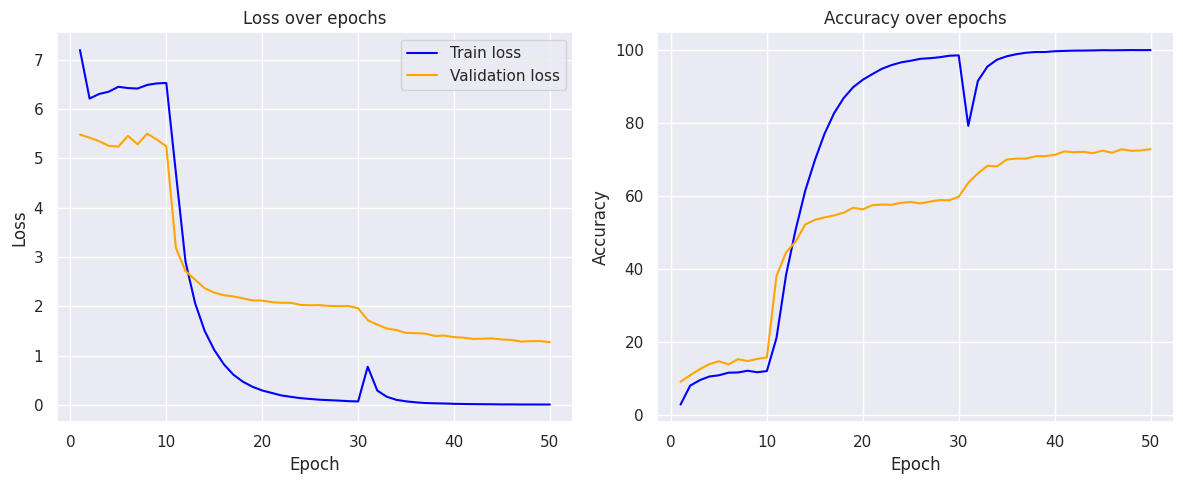

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

ax1.plot(range(1, 51), losses_on_train, label = 'Train loss', color = 'blue')
ax1.plot(range(1, 51), losses_on_val, label = 'Validation loss', color = 'orange')
ax1.set_title('Loss over epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(range(1, 51), accuracy_on_train, label = 'Train accuracy', color = 'blue')
ax2.plot(range(1, 51), accuracy_on_val, label = 'Validation accuracy', color = 'orange')
ax2.set_title('Accuracy over epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

Из графика accuracy видно, что резкому росту этой метрики соответствовали эпохи, на которых производилась разморозка параметров модели.

*  После 10 эпохи были разморожены параметры layer4, после чего наблюдался резкий рост train и val accuracy, причём если val accuracy начала выходить на плато, то train accuracy продолжила рости и этот рост был более быстрый.
*  После 30 эпохи помимо layer4 был разморожен layer3, после чего "просела" метрика на train'e c последующим увеличением через несколько эпох, а на валидации метрика продолжила рост.

# Попытки обучения других моделей

**Модель resnet50**

*   нет аугментации
*   разморожен классификатор
*   используется ReduceLROnPlateau scheduler
*   lr = 0.001


```
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr = 0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 3)
earlystopping = EarlyStopping(mode = 'min', patience = 10)
```

```
Epoch [1/10], train_loss: 6.1873, val Loss: 5.9230, val accuracy: 2.4494%, lr: 0.0010
Epoch [2/10], train_loss: 5.4074, val Loss: 5.6171, val accuracy: 5.9105%, lr: 0.0010
Сохранена модель со значением val loss = 5.6171 на эпохе 2
Epoch [3/10], train_loss: 4.8228, val Loss: 5.4128, val accuracy: 8.4132%, lr: 0.0010
Сохранена модель со значением val loss = 5.4128 на эпохе 3
Epoch [4/10], train_loss: 4.3041, val Loss: 5.2514, val accuracy: 9.8509%, lr: 0.0010
Сохранена модель со значением val loss = 5.2514 на эпохе 4
Epoch [5/10], train_loss: 3.8399, val Loss: 5.1083, val accuracy: 11.2354%, lr: 0.0010
Сохранена модель со значением val loss = 5.1083 на эпохе 5
Epoch [6/10], train_loss: 3.4102, val Loss: 4.9856, val accuracy: 13.8978%, lr: 0.0010
Сохранена модель со значением val loss = 4.9856 на эпохе 6
Epoch [7/10], train_loss: 3.0237, val Loss: 4.8950, val accuracy: 14.3770%, lr: 0.0010
Сохранена модель со значением val loss = 4.8950 на эпохе 7
Epoch [8/10], train_loss: 2.6763, val Loss: 4.8194, val accuracy: 15.1225%, lr: 0.0010
Сохранена модель со значением val loss = 4.8194 на эпохе 8
Epoch [9/10], train_loss: 2.3667, val Loss: 4.7369, val accuracy: 15.4420%, lr: 0.0010
Сохранена модель со значением val loss = 4.7369 на эпохе 9
Epoch [10/10], train_loss: 2.0991, val Loss: 4.6855, val accuracy: 15.2290%, lr: 0.0010
Сохранена модель со значением val loss = 4.6855 на эпохе 10
```



Итоге: Неплохие результаты за 10 эпох в сравнении с resnet34. Однако при дальнейшем обучении accuracy почти не менялся, видимо выйдя на плато, из-за чего обучение решено было прервать.

**Модель resnet50**

* добавлена аугментации
* разморожен классификатор
* используется ExponentialLR scheduler
* более высокий lr = 0.01 по сравнению с предыдущим примером



```
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr = 0.01)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
earlystopping = EarlyStopping(mode = 'min', patience = 10)
```





```
14 мин.
Epoch [1/10], train_loss: 6.8702, val Loss: 5.6965, val accuracy: 5.4846%, lr: 0.0055
Epoch [2/10], train_loss: 2.7436, val Loss: 4.9168, val accuracy: 11.9276%, lr: 0.0060
Сохранена модель со значением val loss = 4.9168 на эпохе 2
Epoch [3/10], train_loss: 1.5958, val Loss: 4.7690, val accuracy: 13.3120%, lr: 0.0061
Сохранена модель со значением val loss = 4.7690 на эпохе 3
Epoch [4/10], train_loss: 0.8752, val Loss: 4.5891, val accuracy: 15.7082%, lr: 0.0062
Сохранена модель со значением val loss = 4.5891 на эпохе 4
Epoch [5/10], train_loss: 0.4521, val Loss: 4.5307, val accuracy: 16.5069%, lr: 0.0062
Сохранена модель со значением val loss = 4.5307 на эпохе 5
Epoch [6/10], train_loss: 0.2582, val Loss: 4.4715, val accuracy: 18.3706%, lr: 0.0062
Сохранена модель со значением val loss = 4.4715 на эпохе 6
Epoch [7/10], train_loss: 0.1630, val Loss: 4.4454, val accuracy: 17.7316%, lr: 0.0063
Сохранена модель со значением val loss = 4.4454 на эпохе 7
Epoch [8/10], train_loss: 0.1138, val Loss: 4.4273, val accuracy: 18.2109%, lr: 0.0063
Сохранена модель со значением val loss = 4.4273 на эпохе 8
Epoch [9/10], train_loss: 0.0841, val Loss: 4.3924, val accuracy: 19.3823%, lr: 0.0063
Сохранена модель со значением val loss = 4.3924 на эпохе 9
Epoch [10/10], train_loss: 0.0665, val Loss: 4.3976, val accuracy: 19.8616%, lr: 0.0063
```



Итог: время обучения возросло из-за использования аугментации, при этом рост accuracy тормозился при дальнейшем обучении и разморозке весов, поэтому я не продолжал обучение этой модели.

**Модель resnet18**
* 30 эпох, аугментированные данные
* разморожен классификатор


```
Epoch [1/31], train_loss: 7.0265, val Loss: 5.3520, val accuracy: 9.4249%, lr: 0.0099
Epoch [2/31], train_loss: 6.0518, val Loss: 5.0903, val accuracy: 12.9925%, lr: 0.0098
Сохранена модель со значением val loss = 5.0903 на эпохе 2
Epoch [3/31], train_loss: 6.0935, val Loss: 5.2635, val accuracy: 12.4068%, lr: 0.0097
Epoch [4/31], train_loss: 6.0798, val Loss: 5.0227, val accuracy: 14.6432%, lr: 0.0096
Сохранена модель со значением val loss = 5.0227 на эпохе 4
Epoch [5/31], train_loss: 6.1438, val Loss: 5.3917, val accuracy: 14.6965%, lr: 0.0095
Epoch [6/31], train_loss: 6.1609, val Loss: 5.1298, val accuracy: 16.9862%, lr: 0.0094
Epoch [7/31], train_loss: 6.1493, val Loss: 5.0834, val accuracy: 15.9744%, lr: 0.0093
Epoch [8/31], train_loss: 6.1541, val Loss: 5.1239, val accuracy: 15.2822%, lr: 0.0092
Epoch [9/31], train_loss: 6.1804, val Loss: 5.0629, val accuracy: 15.3887%, lr: 0.0091
Epoch [10/31], train_loss: 6.1106, val Loss: 5.0964, val accuracy: 15.4952%, lr: 0.0090
Epoch [11/31], train_loss: 6.1163, val Loss: 5.1850, val accuracy: 14.8030%, lr: 0.0090
Epoch [12/31], train_loss: 6.0730, val Loss: 5.1468, val accuracy: 16.4004%, lr: 0.0089
Epoch [13/31], train_loss: 6.0549, val Loss: 5.2186, val accuracy: 14.6432%, lr: 0.0088
Epoch [14/31], train_loss: 6.0212, val Loss: 4.9849, val accuracy: 16.1874%, lr: 0.0087
Сохранена модель со значением val loss = 4.9849 на эпохе 14
Epoch [15/31], train_loss: 5.9952, val Loss: 4.8792, val accuracy: 17.5186%, lr: 0.0086
Сохранена модель со значением val loss = 4.8792 на эпохе 15
Epoch [16/31], train_loss: 5.9634, val Loss: 5.1705, val accuracy: 15.0692%, lr: 0.0085
Epoch [17/31], train_loss: 5.8945, val Loss: 4.9203, val accuracy: 17.5186%, lr: 0.0084
Epoch [18/31], train_loss: 5.9042, val Loss: 5.0066, val accuracy: 16.1874%, lr: 0.0083
Epoch [19/31], train_loss: 5.8891, val Loss: 5.0507, val accuracy: 15.9212%, lr: 0.0083
Epoch [20/31], train_loss: 5.8379, val Loss: 4.8914, val accuracy: 16.7732%, lr: 0.0082
Epoch [21/31], train_loss: 5.8726, val Loss: 4.9121, val accuracy: 17.3589%, lr: 0.0081
Epoch [22/31], train_loss: 5.8332, val Loss: 4.8608, val accuracy: 17.4121%, lr: 0.0080
Сохранена модель со значением val loss = 4.8608 на эпохе 22
Epoch [23/31], train_loss: 5.7611, val Loss: 4.8324, val accuracy: 16.7199%, lr: 0.0079
Сохранена модель со значением val loss = 4.8324 на эпохе 23
Epoch [24/31], train_loss: 5.7389, val Loss: 4.9056, val accuracy: 16.5602%, lr: 0.0079
Epoch [25/31], train_loss: 5.7040, val Loss: 4.7926, val accuracy: 18.9031%, lr: 0.0078
Сохранена модель со значением val loss = 4.7926 на эпохе 25
Epoch [26/31], train_loss: 5.7113, val Loss: 4.9032, val accuracy: 16.6134%, lr: 0.0077
Epoch [27/31], train_loss: 5.6511, val Loss: 4.7834, val accuracy: 17.2524%, lr: 0.0076
Сохранена модель со значением val loss = 4.7834 на эпохе 27
Epoch [28/31], train_loss: 5.6432, val Loss: 4.8573, val accuracy: 16.6134%, lr: 0.0075
Epoch [29/31], train_loss: 5.6402, val Loss: 4.7200, val accuracy: 18.0511%, lr: 0.0075
Сохранена модель со значением val loss = 4.7200 на эпохе 29
Epoch [30/31], train_loss: 5.5610, val Loss: 4.7854, val accuracy: 17.0927%, lr: 0.0074
```



Итог: несмотря на то, что модель обучалась 30 эпох, метрика не росла выше 19 %. Возможно, при большем количестве эпох и последовательной разморозке слоёв feature extractor'а удалось бы достичь необходимой точности, этого я не проверял.

# Обучение нейросети для 3 части пайплайна распознавания лиц на ArcFace loss. Использована нейросеть ResNet34, предобученная на ImageNet

# Реализация классов ArcFace и ArcFaceModel

In [70]:
import torch.nn.functional as F
import math

In [71]:
class ArcFace(nn.Module):
    """
    Имплементация ArcFace Loss (Additive Angular Margin Loss)

    Параметры:
        in_features (int): размерность входных эмбеддингов (512 в случае resnet34)
        out_features (int): количество классов
        s (float): scale коэффициент для логитов (default 64.0)
        m (float): margin, добавляемый для улучшения разделимости классов (default 0.5)
    """

    def __init__(self, in_features, out_features, s=64.0, m=0.5):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        '''
        Параметры:
            input (torch.Tensor): эмбеддинги размерности [batch_size, in_features].
            label (torch.Tensor): истинные метки классов размерности [batch_size].

        Возвращает:
            torch.Tensor: модифицированные логиты, которые мы уже будем подавать в softmax
        '''

        input = F.normalize(input, p = 2, dim = 1)
        weight = F.normalize(self.weight, p = 2, dim = 1)
        cosine = F.linear(input, weight)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        alpha = cosine * math.cos(self.m) - sine * math.sin(self.m)
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * alpha) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [72]:
class ArcFaceModel(nn.Module):
    '''
    Модель ArcFace, созданная на основе resnet34
    '''
    def __init__(self):
        super(ArcFaceModel, self).__init__()

        self.backbone = models.resnet34(weights = 'DEFAULT')
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 512)
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.arcface = ArcFace(512, 500)

    def forward(self, x, labels=None):
        '''
        Параметры:
            x (torch.Tensor): входные изображения размерности [batch_size, 3, H, W]
            labels (torch.Tensor, optional): истинные метки классов. При их передаче используется слой ArcFace
        Возвращает:
            torch.Tensor: возвращает эмбеддинги (при отсутствии labels), логиты (при наличии labels)
        '''

        x = self.backbone(x)
        x = self.batch_norm1(x)
        if labels is not None:
            x = self.arcface(x, labels)
        return x

In [73]:
arcface_model = ArcFaceModel()

# 1 - й этап обучения: разморожены fc и ArcFace слои, 15 эпох

In [ ]:
for name, param in arcface_model.named_parameters():
    if "fc" in name or "arcface" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
for name, param in arcface_model.named_parameters():
    status = "разморожен" if param.requires_grad else "заморожен"
    print(f"Слой: {name}, Статус: {status}")

Слой: backbone.conv1.weight, Статус: заморожен
Слой: backbone.bn1.weight, Статус: заморожен
Слой: backbone.bn1.bias, Статус: заморожен
Слой: backbone.layer1.0.conv1.weight, Статус: заморожен
Слой: backbone.layer1.0.bn1.weight, Статус: заморожен
Слой: backbone.layer1.0.bn1.bias, Статус: заморожен
Слой: backbone.layer1.0.conv2.weight, Статус: заморожен
Слой: backbone.layer1.0.bn2.weight, Статус: заморожен
Слой: backbone.layer1.0.bn2.bias, Статус: заморожен
Слой: backbone.layer1.1.conv1.weight, Статус: заморожен
Слой: backbone.layer1.1.bn1.weight, Статус: заморожен
Слой: backbone.layer1.1.bn1.bias, Статус: заморожен
Слой: backbone.layer1.1.conv2.weight, Статус: заморожен
Слой: backbone.layer1.1.bn2.weight, Статус: заморожен
Слой: backbone.layer1.1.bn2.bias, Статус: заморожен
Слой: backbone.layer1.2.conv1.weight, Статус: заморожен
Слой: backbone.layer1.2.bn1.weight, Статус: заморожен
Слой: backbone.layer1.2.bn1.bias, Статус: заморожен
Слой: backbone.layer1.2.conv2.weight, Статус: заморожен

In [ ]:
arcface_model

ArcFaceModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
arcface_model = arcface_model.to(device)
optimizer = torch.optim.Adam(arcface_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.99)
earlystopping = EarlyStopping(mode = 'min', patience = 10)
start_epoch = 1
n_epochs = 15

In [ ]:
train_model(arcface_model, train_loader, val_loader, criterion, optimizer, earlystopping, start_epoch, n_epochs)

Epoch [1/15], train_loss: 5.2798, val Loss: 4.7996, val accuracy: 16.7199 %, train_accuracy: 10.9755 %, lr: 0.0010


Epoch [2/15], train_loss: 4.0039, val Loss: 4.5658, val accuracy: 22.4175 %, train_accuracy: 39.0215 %, lr: 0.0010
Сохранена модель со значением val loss = 4.5658 на эпохе 2


Epoch [3/15], train_loss: 3.6066, val Loss: 4.4700, val accuracy: 24.9734 %, train_accuracy: 51.1002 %, lr: 0.0010
Сохранена модель со значением val loss = 4.4700 на эпохе 3


Epoch [4/15], train_loss: 3.4051, val Loss: 4.4372, val accuracy: 25.5059 %, train_accuracy: 57.4731 %, lr: 0.0010
Сохранена модель со значением val loss = 4.4372 на эпохе 4


Epoch [5/15], train_loss: 3.2765, val Loss: 4.4195, val accuracy: 25.6656 %, train_accuracy: 61.5724 %, lr: 0.0010
Сохранена модель со значением val loss = 4.4195 на эпохе 5


Epoch [6/15], train_loss: 3.1905, val Loss: 4.3893, val accuracy: 25.9318 %, train_accuracy: 64.3522 %, lr: 0.0009
Сохранена модель со значением val loss = 4.3893 на эпохе 6


Epoch [7/15], train_loss: 3.1192, val Loss: 4.3963, val accuracy: 26.8371 %, train_accuracy: 66.2834 %, lr: 0.0009


Epoch [8/15], train_loss: 3.0656, val Loss: 4.3835, val accuracy: 27.7955 %, train_accuracy: 68.0331 %, lr: 0.0009
Сохранена модель со значением val loss = 4.3835 на эпохе 8


Epoch [9/15], train_loss: 3.0221, val Loss: 4.3838, val accuracy: 27.7955 %, train_accuracy: 69.6190 %, lr: 0.0009


Epoch [10/15], train_loss: 2.9882, val Loss: 4.3608, val accuracy: 28.4878 %, train_accuracy: 70.5349 %, lr: 0.0009
Сохранена модель со значением val loss = 4.3608 на эпохе 10


Epoch [11/15], train_loss: 2.9537, val Loss: 4.3755, val accuracy: 27.2630 %, train_accuracy: 71.8340 %, lr: 0.0009


Epoch [12/15], train_loss: 2.9303, val Loss: 4.3740, val accuracy: 26.7838 %, train_accuracy: 72.3812 %, lr: 0.0009


Epoch [13/15], train_loss: 2.9020, val Loss: 4.3564, val accuracy: 28.1150 %, train_accuracy: 73.1127 %, lr: 0.0009
Сохранена модель со значением val loss = 4.3564 на эпохе 13


Epoch [14/15], train_loss: 2.8865, val Loss: 4.3621, val accuracy: 26.5176 %, train_accuracy: 73.7184 %, lr: 0.0009


Epoch [15/15], train_loss: 2.8705, val Loss: 4.3622, val accuracy: 28.0085 %, train_accuracy: 74.5611 %, lr: 0.0009


{'loss': {'train_loss': [5.279750959197087,
   4.003872010245252,
   3.6065984786446417,
   3.405121255276808,
   3.2765339310489483,
   3.1904653684416813,
   3.119244237444294,
   3.0656405295898663,
   3.022092548768912,
   2.988231573531877,
   2.9537106805772924,
   2.930346197156764,
   2.902035090460706,
   2.886451130482688,
   2.87045901035195],
  'val_loss': [4.799626171588898,
   4.565829396247864,
   4.470033228397369,
   4.43723464012146,
   4.419537961483002,
   4.38930732011795,
   4.3963305950164795,
   4.383482217788696,
   4.3837597370147705,
   4.3607818484306335,
   4.375489175319672,
   4.374015033245087,
   4.356374979019165,
   4.3620612025260925,
   4.36219584941864]},
 'metric': {'train_acc': [10.975538389513108,
   39.02153558052434,
   51.100187265917604,
   57.47308052434457,
   61.57244850187266,
   64.35217696629213,
   66.28335674157303,
   68.03312265917603,
   69.6190308988764,
   70.53487827715355,
   71.83403558052434,
   72.3812031835206,
   73.11271

In [ ]:
train_loss_epochs_1_15 = [5.279750959197087,
   4.003872010245252,
   3.6065984786446417,
   3.405121255276808,
   3.2765339310489483,
   3.1904653684416813,
   3.119244237444294,
   3.0656405295898663,
   3.022092548768912,
   2.988231573531877,
   2.9537106805772924,
   2.930346197156764,
   2.902035090460706,
   2.886451130482688,
   2.87045901035195]

In [ ]:
val_loss_epochs_1_15 = [4.799626171588898,
   4.565829396247864,
   4.470033228397369,
   4.43723464012146,
   4.419537961483002,
   4.38930732011795,
   4.3963305950164795,
   4.383482217788696,
   4.3837597370147705,
   4.3607818484306335,
   4.375489175319672,
   4.374015033245087,
   4.356374979019165,
   4.3620612025260925,
   4.36219584941864]

In [ ]:
train_acc_epochs_1_15 = [10.975538389513108,
   39.02153558052434,
   51.100187265917604,
   57.47308052434457,
   61.57244850187266,
   64.35217696629213,
   66.28335674157303,
   68.03312265917603,
   69.6190308988764,
   70.53487827715355,
   71.83403558052434,
   72.3812031835206,
   73.1127106741573,
   73.71839887640449,
   74.56109550561797]

In [ ]:
val_acc_epochs_1_15 = [16.719914802981897,
   22.417465388711395,
   24.973375931842387,
   25.505857294994676,
   25.66560170394036,
   25.931842385516507,
   26.837060702875398,
   27.79552715654952,
   27.79552715654952,
   28.4877529286475,
   27.263045793397232,
   26.78381256656017,
   28.115015974440894,
   26.517571884984026,
   28.008519701810435]

# 2 - й этап обучения: разморожены fc и ArcFace слои и layer4 feature extractor'а, 15 эпох

Загрузим состояние модели, сохранённой на 13 - й эпохе, и продолжим обучение. Разморозим теперь веса слоя layer4

In [ ]:
load_model_state = torch.load('model_state_dict_epoch_13.pt')

<ipython-input-68-7cb1507424ba>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model_state = torch.load('model_state_dict_epoch_13.pt')


In [ ]:
arcface_model = ArcFaceModel()

In [ ]:
for name, param in arcface_model.named_parameters():
    if "fc" in name or "arcface" in name or "layer4" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
for name, param in arcface_model.named_parameters():
    status = "разморожен" if param.requires_grad else "заморожен"
    print(f"Слой: {name}, Статус: {status}")

Слой: backbone.conv1.weight, Статус: заморожен
Слой: backbone.bn1.weight, Статус: заморожен
Слой: backbone.bn1.bias, Статус: заморожен
Слой: backbone.layer1.0.conv1.weight, Статус: заморожен
Слой: backbone.layer1.0.bn1.weight, Статус: заморожен
Слой: backbone.layer1.0.bn1.bias, Статус: заморожен
Слой: backbone.layer1.0.conv2.weight, Статус: заморожен
Слой: backbone.layer1.0.bn2.weight, Статус: заморожен
Слой: backbone.layer1.0.bn2.bias, Статус: заморожен
Слой: backbone.layer1.1.conv1.weight, Статус: заморожен
Слой: backbone.layer1.1.bn1.weight, Статус: заморожен
Слой: backbone.layer1.1.bn1.bias, Статус: заморожен
Слой: backbone.layer1.1.conv2.weight, Статус: заморожен
Слой: backbone.layer1.1.bn2.weight, Статус: заморожен
Слой: backbone.layer1.1.bn2.bias, Статус: заморожен
Слой: backbone.layer1.2.conv1.weight, Статус: заморожен
Слой: backbone.layer1.2.bn1.weight, Статус: заморожен
Слой: backbone.layer1.2.bn1.bias, Статус: заморожен
Слой: backbone.layer1.2.conv2.weight, Статус: заморожен

In [ ]:
arcface_model.load_state_dict(load_model_state['state_model'])

<All keys matched successfully>

In [ ]:
arcface_model = arcface_model.to(device)
optimizer = torch.optim.Adam(arcface_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.99)
earlystopping = EarlyStopping(mode = 'min', patience = 10)
start_epoch = 16
n_epochs = 15

In [ ]:
train_model(arcface_model, train_loader, val_loader, criterion, optimizer, earlystopping, start_epoch, n_epochs)

Epoch [16/30], train_loss: 2.7638, val Loss: 2.7023, val accuracy: 57.7742 %, train_accuracy: 65.3207 %, lr: 0.0010


Epoch [17/30], train_loss: 1.0033, val Loss: 2.2156, val accuracy: 65.4952 %, train_accuracy: 95.3301 %, lr: 0.0010
Сохранена модель со значением val loss = 2.2156 на эпохе 17


Epoch [18/30], train_loss: 0.3179, val Loss: 1.9972, val accuracy: 69.0096 %, train_accuracy: 99.6957 %, lr: 0.0010
Сохранена модель со значением val loss = 1.9972 на эпохе 18


Epoch [19/30], train_loss: 0.1547, val Loss: 1.8462, val accuracy: 70.1810 %, train_accuracy: 99.9649 %, lr: 0.0010
Сохранена модель со значением val loss = 1.8462 на эпохе 19


Epoch [20/30], train_loss: 0.1125, val Loss: 1.8612, val accuracy: 71.3525 %, train_accuracy: 99.9824 %, lr: 0.0010


Epoch [21/30], train_loss: 0.0981, val Loss: 1.8108, val accuracy: 70.2875 %, train_accuracy: 99.9707 %, lr: 0.0009
Сохранена модель со значением val loss = 1.8108 на эпохе 21


Epoch [22/30], train_loss: 0.0976, val Loss: 1.8150, val accuracy: 70.2343 %, train_accuracy: 99.9649 %, lr: 0.0009


Epoch [23/30], train_loss: 0.1038, val Loss: 1.8565, val accuracy: 70.2343 %, train_accuracy: 99.9093 %, lr: 0.0009


Epoch [24/30], train_loss: 0.1083, val Loss: 1.8387, val accuracy: 68.1044 %, train_accuracy: 99.8654 %, lr: 0.0009


Epoch [25/30], train_loss: 0.1090, val Loss: 1.8637, val accuracy: 67.3056 %, train_accuracy: 99.7893 %, lr: 0.0009


Epoch [26/30], train_loss: 0.1006, val Loss: 1.8666, val accuracy: 68.9563 %, train_accuracy: 99.8713 %, lr: 0.0009


Epoch [27/30], train_loss: 0.0962, val Loss: 1.8562, val accuracy: 67.8914 %, train_accuracy: 99.8215 %, lr: 0.0009


Epoch [28/30], train_loss: 0.0877, val Loss: 1.7754, val accuracy: 69.9148 %, train_accuracy: 99.8830 %, lr: 0.0009
Сохранена модель со значением val loss = 1.7754 на эпохе 28


Epoch [29/30], train_loss: 0.0850, val Loss: 1.9053, val accuracy: 66.2939 %, train_accuracy: 99.8566 %, lr: 0.0009


Epoch [30/30], train_loss: 0.0789, val Loss: 1.8029, val accuracy: 68.3174 %, train_accuracy: 99.8683 %, lr: 0.0009


{'loss': {'train_loss': [2.7638356712327075,
   1.0033430252502213,
   0.3178742807080497,
   0.15468479804138638,
   0.11245321393457812,
   0.098146649049734,
   0.09758086246785833,
   0.10379302782465273,
   0.10830800246391724,
   0.10897990899966724,
   0.10058516258401658,
   0.0962278496529629,
   0.08772817971323853,
   0.08495615703512484,
   0.07886406217715633],
  'val_loss': [2.7023341059684753,
   2.21562023460865,
   1.9971803724765778,
   1.8461637049913406,
   1.8612239211797714,
   1.8108424246311188,
   1.8150472044944763,
   1.8565469086170197,
   1.8387005478143692,
   1.8637216836214066,
   1.8665576577186584,
   1.8562211394309998,
   1.775360494852066,
   1.9053499549627304,
   1.8029014617204666]},
 'metric': {'train_acc': [65.32069288389513,
   95.33005617977528,
   99.69569288389513,
   99.96488764044943,
   99.98244382022472,
   99.97073970037454,
   99.96488764044943,
   99.90929307116104,
   99.86540262172285,
   99.78932584269663,
   99.87125468164794,
  

In [ ]:
train_loss_epochs_16_30 = [2.7638356712327075,
   1.0033430252502213,
   0.3178742807080497,
   0.15468479804138638,
   0.11245321393457812,
   0.098146649049734,
   0.09758086246785833,
   0.10379302782465273,
   0.10830800246391724,
   0.10897990899966724,
   0.10058516258401658,
   0.0962278496529629,
   0.08772817971323853,
   0.08495615703512484,
   0.07886406217715633]

In [ ]:
val_loss_epochs_16_30 = [2.7023341059684753,
   2.21562023460865,
   1.9971803724765778,
   1.8461637049913406,
   1.8612239211797714,
   1.8108424246311188,
   1.8150472044944763,
   1.8565469086170197,
   1.8387005478143692,
   1.8637216836214066,
   1.8665576577186584,
   1.8562211394309998,
   1.775360494852066,
   1.9053499549627304,
   1.8029014617204666]

In [ ]:
train_acc_epochs_16_30 = [65.32069288389513,
   95.33005617977528,
   99.69569288389513,
   99.96488764044943,
   99.98244382022472,
   99.97073970037454,
   99.96488764044943,
   99.90929307116104,
   99.86540262172285,
   99.78932584269663,
   99.87125468164794,
   99.82151217228464,
   99.88295880149813,
   99.85662453183521,
   99.86832865168539]

In [ ]:
val_acc_epochs_16_30 = [57.774227902023426,
   65.49520766773163,
   69.00958466453675,
   70.18104366347178,
   71.35250266240682,
   70.28753993610223,
   70.234291799787,
   70.234291799787,
   68.10436634717784,
   67.30564430244941,
   68.95633652822151,
   67.89137380191693,
   69.91480298189563,
   66.29392971246007,
   68.31735889243876]

# 3 - й этап: разморожены fc и ArcFace слои, а также layer4 и layer3 feature extractor'a

Загрузим состояние модели, сохранённой на 28 - й эпохе

In [ ]:
load_model_state = torch.load('model_state_dict_epoch_28.pt')

<ipython-input-75-deb4e6d1c17b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model_state = torch.load('model_state_dict_epoch_28.pt')


In [ ]:
arcface_model = ArcFaceModel()

In [ ]:
for name, param in arcface_model.named_parameters():
    if "fc" in name or "arcface" in name or "layer4" in name or "layer3" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
for name, param in arcface_model.named_parameters():
    status = "разморожен" if param.requires_grad else "заморожен"
    print(f"Слой: {name}, Статус: {status}")

Слой: backbone.conv1.weight, Статус: заморожен
Слой: backbone.bn1.weight, Статус: заморожен
Слой: backbone.bn1.bias, Статус: заморожен
Слой: backbone.layer1.0.conv1.weight, Статус: заморожен
Слой: backbone.layer1.0.bn1.weight, Статус: заморожен
Слой: backbone.layer1.0.bn1.bias, Статус: заморожен
Слой: backbone.layer1.0.conv2.weight, Статус: заморожен
Слой: backbone.layer1.0.bn2.weight, Статус: заморожен
Слой: backbone.layer1.0.bn2.bias, Статус: заморожен
Слой: backbone.layer1.1.conv1.weight, Статус: заморожен
Слой: backbone.layer1.1.bn1.weight, Статус: заморожен
Слой: backbone.layer1.1.bn1.bias, Статус: заморожен
Слой: backbone.layer1.1.conv2.weight, Статус: заморожен
Слой: backbone.layer1.1.bn2.weight, Статус: заморожен
Слой: backbone.layer1.1.bn2.bias, Статус: заморожен
Слой: backbone.layer1.2.conv1.weight, Статус: заморожен
Слой: backbone.layer1.2.bn1.weight, Статус: заморожен
Слой: backbone.layer1.2.bn1.bias, Статус: заморожен
Слой: backbone.layer1.2.conv2.weight, Статус: заморожен

In [ ]:
arcface_model.load_state_dict(load_model_state['state_model'])

<All keys matched successfully>

In [ ]:
arcface_model = arcface_model.to(device)
optimizer = torch.optim.Adam(arcface_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.99)
earlystopping = EarlyStopping(mode = 'min', patience = 10)
start_epoch = 31
n_epochs = 10

In [ ]:
train_model(arcface_model, train_loader, val_loader, criterion, optimizer, earlystopping, start_epoch, n_epochs)

Epoch [31/40], train_loss: 0.2563, val Loss: 1.6389, val accuracy: 71.5655 %, train_accuracy: 98.2415 %, lr: 0.0010


Epoch [32/40], train_loss: 0.1387, val Loss: 1.6419, val accuracy: 70.5005 %, train_accuracy: 99.2509 %, lr: 0.0010


Epoch [33/40], train_loss: 0.1062, val Loss: 1.4731, val accuracy: 74.1214 %, train_accuracy: 99.5465 %, lr: 0.0010
Сохранена модель со значением val loss = 1.4731 на эпохе 33


Epoch [34/40], train_loss: 0.0955, val Loss: 1.5647, val accuracy: 71.3525 %, train_accuracy: 99.5757 %, lr: 0.0010


Epoch [35/40], train_loss: 0.0957, val Loss: 1.4055, val accuracy: 75.7188 %, train_accuracy: 99.5055 %, lr: 0.0010
Сохранена модель со значением val loss = 1.4055 на эпохе 35


Epoch [36/40], train_loss: 0.0873, val Loss: 1.4727, val accuracy: 73.6422 %, train_accuracy: 99.6489 %, lr: 0.0009


Epoch [37/40], train_loss: 0.0814, val Loss: 1.4027, val accuracy: 74.2812 %, train_accuracy: 99.6606 %, lr: 0.0009
Сохранена модель со значением val loss = 1.4027 на эпохе 37


Epoch [38/40], train_loss: 0.0780, val Loss: 1.3476, val accuracy: 76.5176 %, train_accuracy: 99.6547 %, lr: 0.0009
Сохранена модель со значением val loss = 1.3476 на эпохе 38


Epoch [39/40], train_loss: 0.0691, val Loss: 1.3497, val accuracy: 76.7306 %, train_accuracy: 99.7542 %, lr: 0.0009


Epoch [40/40], train_loss: 0.0650, val Loss: 1.3131, val accuracy: 77.3163 %, train_accuracy: 99.7396 %, lr: 0.0009
Сохранена модель со значением val loss = 1.3131 на эпохе 40


{'loss': {'train_loss': [0.2562950686621132,
   0.1386793791246948,
   0.10617050600808058,
   0.09549730321142211,
   0.09568351724032145,
   0.08734181879171685,
   0.08137319862508952,
   0.07799047526361337,
   0.0690693576166879,
   0.0650167132157888],
  'val_loss': [1.6389126479625702,
   1.6419153660535812,
   1.4730921387672424,
   1.564653992652893,
   1.405451461672783,
   1.4727073013782501,
   1.4027459770441055,
   1.3476243615150452,
   1.34969162940979,
   1.3131069540977478]},
 'metric': {'train_acc': [98.24145599250936,
   99.25093632958801,
   99.54646535580524,
   99.57572565543072,
   99.50550093632958,
   99.64887640449439,
   99.66058052434457,
   99.65472846441948,
   99.75421348314607,
   99.73958333333333],
  'val_acc': [71.56549520766774,
   70.50053248136315,
   74.12140575079871,
   71.35250266240682,
   75.71884984025559,
   73.64217252396166,
   74.28115015974441,
   76.51757188498402,
   76.73056443024494,
   77.31629392971246]},
 'lr': [0.00099,
  0.000

# Проверка модели на тестовых данных

In [74]:
load_model_state = torch.load('model_state_dict_epoch_40.pt')

<ipython-input-74-d83154cd1a62>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model_state = torch.load('model_state_dict_epoch_40.pt')


In [75]:
arcface_model = ArcFaceModel()

In [76]:
arcface_model.load_state_dict(load_model_state['state_model'])

<All keys matched successfully>

In [79]:
arcface_model = arcface_model.to(device)
criterion = nn.CrossEntropyLoss()

In [80]:
results_on_test = test_model(arcface_model, criterion, test_loader)

In [81]:
test_acc = results_on_test['test_acc']
test_loss = results_on_test['test_loss']
print(f'Test accuracy = {test_acc:.4f} %, test loss = {test_loss:.4f}')

Test accuracy = 76.7778 %, test loss = 1.3752


***Таким образом, на тесте достигнута accuracy > 76.7%***

# Графики функции потерь и метрики на тренировке и валидации

In [ ]:
train_loss_epochs_31_40 = load_model_state['loss']['train_loss']
train_acc_epochs_31_40 = load_model_state['metric']['train_acc']
val_loss_epochs_31_40 = load_model_state['loss']['val_loss']
val_acc_epochs_31_40 = load_model_state['metric']['val_acc']

In [ ]:
losses_on_train = train_loss_epochs_1_15 + train_loss_epochs_16_30 + train_loss_epochs_31_40
losses_on_val = val_loss_epochs_1_15 + val_loss_epochs_16_30 + val_loss_epochs_31_40
accuracy_on_val = val_acc_epochs_1_15 + val_acc_epochs_16_30 + val_acc_epochs_31_40
accuracy_on_train = train_acc_epochs_1_15 + train_acc_epochs_16_30 + train_acc_epochs_31_40
sns.set_theme(style="darkgrid")

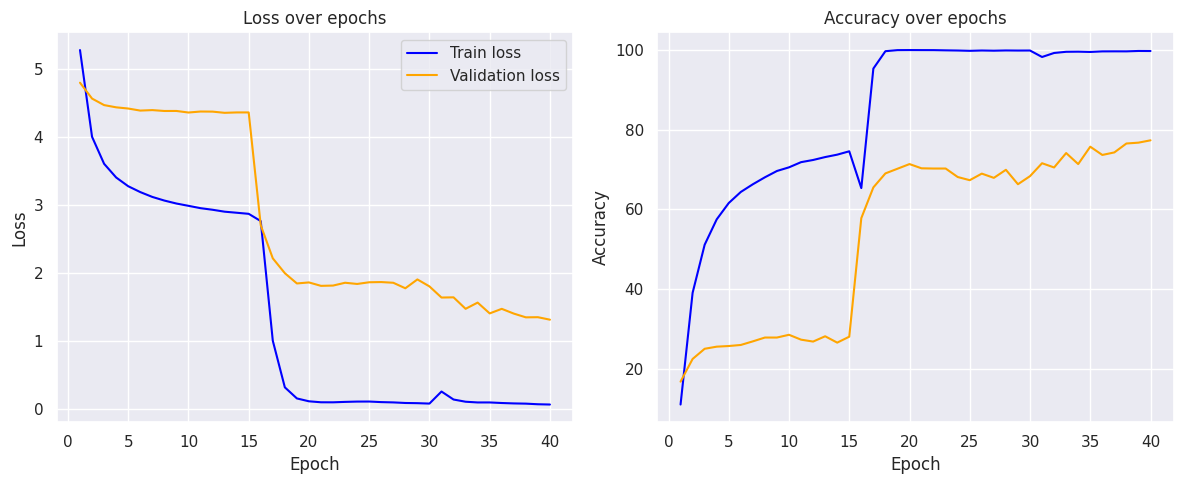

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

ax1.plot(range(1, 41), losses_on_train, label = 'Train loss', color = 'blue')
ax1.plot(range(1, 41), losses_on_val, label = 'Validation loss', color = 'orange')
ax1.set_title('Loss over epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(range(1, 41), accuracy_on_train, label = 'Train accuracy', color = 'blue')
ax2.plot(range(1, 41), accuracy_on_val, label = 'Validation accuracy', color = 'orange')
ax2.set_title('Accuracy over epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

Графики в целом похожи на то, что мы получили при обучении на CE loss, однако есть и различия.

Схоже то, что при разморозке слоя feature extractor'а происходит резкое падение лосса и резкое увеличение accuracy.

Из различий я заметил:


*   loss на train всегда меньше чем на валидации в то время как при обучении на CE loss в начале loss на train был даже выше чем на валидации
*   модель более быстро вышла на почти 100 - процентную точность на train: примерно к 18 эпохе. В случае CE loss такой же результат был только к 40 эпохе.
* модель более быстро обучилась до желаемой точности, за меньшее число эпох

Предполагаю, что если бы я продолжал обучение, то удалось бы ещё улучшить accuracy, так как из графика видно, что accuracy ещё не вышла на плато и, скорее всего, продолжила бы расти.



